<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/003_1_02_PyTorch_CNN_Pneumonia_Tips_0713.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os # path
from glob import glob # search file
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# PyTorch
import torch
from torch import nn
import torchvision
from torchsummary import summary # model summary

In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

In [ ]:
# download from google drive
!pip install --upgrade gdown
!gdown --fuzzy 1fIViA1w8MVJJZJcAjMwapHIYazuyTczE --output pneumonia.zip
# unzip dataset file
!unzip -q pneumonia.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1fIViA1w8MVJJZJcAjMwapHIYazuyTczE
From (redirected): https://drive.google.com/uc?id=1fIViA1w8MVJJZJcAjMwapHIYazuyTczE&confirm=t&uuid=92ad48ed-c385-4536-8cd9-15f9be904b1c
To: /content/pneumonia.zip
100% 118M/118M [00:02<00:00, 46.4MB/s]


### Data

#### Check your data first

In [ ]:
IMG_SIZE = 256 # 32x, 16x
all_class = ['normal', 'bacteria', 'virus']
class_map = {cls: i for i, cls in enumerate(all_class)}
#  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [ ]:
# read all paths
# *: all
img_paths_train = sorted(glob('pneumonia/train/*/*.jpeg'))
# img_paths_train = glob('pneumonia/train/normal/*.jpeg') + glob('pneumonia/train/pneumonia/*.jpeg')

img_paths_test = sorted(glob('pneumonia/val/*/*.jpeg'))

In [ ]:
img_paths_train[:3]

['pneumonia/train/normal/IM-0158-0001.jpeg',
 'pneumonia/train/normal/IM-0164-0001.jpeg',
 'pneumonia/train/normal/IM-0199-0001.jpeg']

In [ ]:
# number of images
len(img_paths_train), len(img_paths_test)

(150, 100)

pneumonia/train/pneumonia/person1010_virus_1695.jpeg
(307, 502, 3)


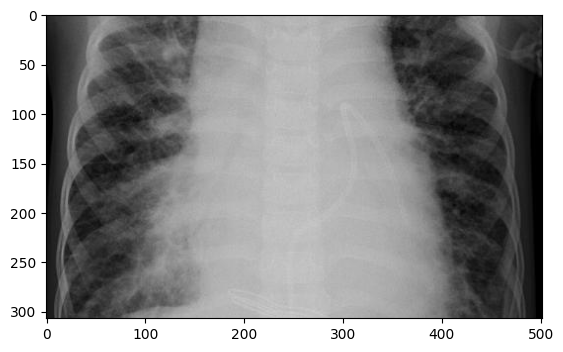

In [ ]:
# show image
path = img_paths_train[100]
img = cv2.imread(path)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()


In [ ]:
# Extract img class
# os.sep: /
print(path)
print(path.split(os.sep))
cls = path.split(os.sep)[-2]
print(cls)

pneumonia/train/pneumonia/person1010_virus_1695.jpeg
['pneumonia', 'train', 'pneumonia', 'person1010_virus_1695.jpeg']
pneumonia


In [ ]:

# Get file class index

# for pneumonia class
if cls == 'pneumonia':
    # get filename
    filename = path.split(os.sep)[-1]
    print(filename)
    # get pneumonia class
    cls_pneumonia = filename.split('_')[1]
    print(cls_pneumonia)
    cls_idx = class_map[cls_pneumonia]
    print(cls_idx)
# for normal class
else:
    cls_idx = class_map[cls]

person1010_virus_1695.jpeg
virus
2


In [ ]:
cls_idx

2

#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   __getitem__() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


Pixel value rescale

*   0~1
*   -1~+1 : (x/127.5) - 1
* (x-x.mean()) / x.std()


#### Dataset + Data Augmentation

In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia

class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, class_map, aug):
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map

        self.seq = seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5), # 50% vertical flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -10 ~ +10 degree
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.aug = aug
    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        if self.aug:
            img = self.seq.augment_image(img)
        img = img / 255. # 0~255 -> 0.~1.

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        if cls == 'pneumonia':
            # get filename
            filename = path.split(os.sep)[-1]
            # get pneumonia class
            cls = filename.split('_')[1]
        cls_idx = self.class_map[cls]

        # transform img to tensor
        img = torch.tensor(img, dtype=torch.float)
        # channel last -> channel first
        # np.swapaxis()
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx

In [ ]:
img_paths_train

['pneumonia/train/normal/IM-0158-0001.jpeg',
 'pneumonia/train/normal/IM-0164-0001.jpeg',
 'pneumonia/train/normal/IM-0199-0001.jpeg',
 'pneumonia/train/normal/IM-0206-0001.jpeg',
 'pneumonia/train/normal/IM-0209-0001.jpeg',
 'pneumonia/train/normal/IM-0244-0001.jpeg',
 'pneumonia/train/normal/IM-0311-0001.jpeg',
 'pneumonia/train/normal/IM-0314-0001.jpeg',
 'pneumonia/train/normal/IM-0324-0001.jpeg',
 'pneumonia/train/normal/IM-0333-0001.jpeg',
 'pneumonia/train/normal/IM-0356-0001.jpeg',
 'pneumonia/train/normal/IM-0370-0001.jpeg',
 'pneumonia/train/normal/IM-0409-0001.jpeg',
 'pneumonia/train/normal/IM-0435-0001.jpeg',
 'pneumonia/train/normal/IM-0458-0001.jpeg',
 'pneumonia/train/normal/IM-0481-0001.jpeg',
 'pneumonia/train/normal/IM-0488-0001.jpeg',
 'pneumonia/train/normal/IM-0563-0001.jpeg',
 'pneumonia/train/normal/IM-0584-0001.jpeg',
 'pneumonia/train/normal/IM-0605-0001.jpeg',
 'pneumonia/train/normal/IM-0608-0001-0001.jpeg',
 'pneumonia/train/normal/IM-0629-0001.jpeg',
 'pne

In [ ]:
# Build dataset
train_ds = Dataset(img_paths_train, IMG_SIZE, class_map)
val_ds = Dataset(img_paths_test, IMG_SIZE, class_map)

In [ ]:
# Number of samples
len(train_ds), len(val_ds)

(150, 100)

In [ ]:
# Build DataLoaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

torch.Size([3, 256, 256]) tensor(0) normal


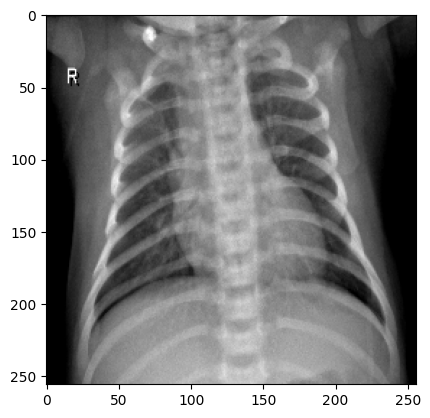

In [ ]:
img, label = train_ds[0]
print(img.shape, label, all_class[label])

img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
plt.imshow(img)
plt.show()

In [ ]:
img, label

(tensor([[[0.0980, 0.0980, 0.0980],
          [0.0706, 0.0706, 0.0706],
          [0.0588, 0.0588, 0.0588],
          ...,
          [0.1451, 0.1451, 0.1451],
          [0.1373, 0.1373, 0.1373],
          [0.1490, 0.1490, 0.1490]],
 
         [[0.1020, 0.1020, 0.1020],
          [0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745],
          ...,
          [0.1686, 0.1686, 0.1686],
          [0.1451, 0.1451, 0.1451],
          [0.1373, 0.1373, 0.1373]],
 
         [[0.1725, 0.1725, 0.1725],
          [0.1647, 0.1647, 0.1647],
          [0.1686, 0.1686, 0.1686],
          ...,
          [0.1569, 0.1569, 0.1569],
          [0.1451, 0.1451, 0.1451],
          [0.1412, 0.1412, 0.1412]],
 
         ...,
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0

### Model



*   Must implement
    1.   **\_\_init\_\_**(): layer **initialization**
    2.   **forward**(): connect **Input** to **Ouput**



*   Model architecture
    1.   Feature extractor
    2.   Flatten
    3.   Classifier



### Model Tips

1.   Batch Normalization
2.   Dropout

In [ ]:
class ConvBN(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, kernel_size=3, padding='same')
        self.bn = nn.BatchNorm2d(num_features=cout)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.act(x)

class CNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBN(3, 16),
            ConvBN(16, 16),
            nn.MaxPool2d(kernel_size=2),

            ConvBN(16, 32),
            ConvBN(32, 32),
            nn.MaxPool2d(kernel_size=2),

            ConvBN(32, 64),
            ConvBN(64, 64),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten() # (64, 32, 32) -> (64*32*32)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64*32*32, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASS),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [ ]:
# Build a model and move to GPU device
model = CNN(kernel_size=7).to(device)

In [ ]:
print(model)

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=same

In [ ]:
# Model summary
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]          50,208
              ReLU-4         [-1, 32, 256, 256]               0
         MaxPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]         100,416
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]         200,768
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         401,536
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         802,944
             ReLU-14          [-1, 128,

### Training



1.   Optimizer
2.   Earlystoping



In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.0910, train_acc: 0.540     val_loss: 1.0959, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.0669, train_acc: 0.667     val_loss: 1.0935, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.0322, train_acc: 0.667     val_loss: 1.0939, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.9784, train_acc: 0.667     val_loss: 1.1093, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.9232, train_acc: 0.667     val_loss: 1.1542, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.8733, train_acc: 0.667     val_loss: 1.2205, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.8482, train_acc: 0.667     val_loss: 1.2926, val_acc: 0.500 


  0%|          | 0/5 [00:00<?, ?it/s]

#### Logs

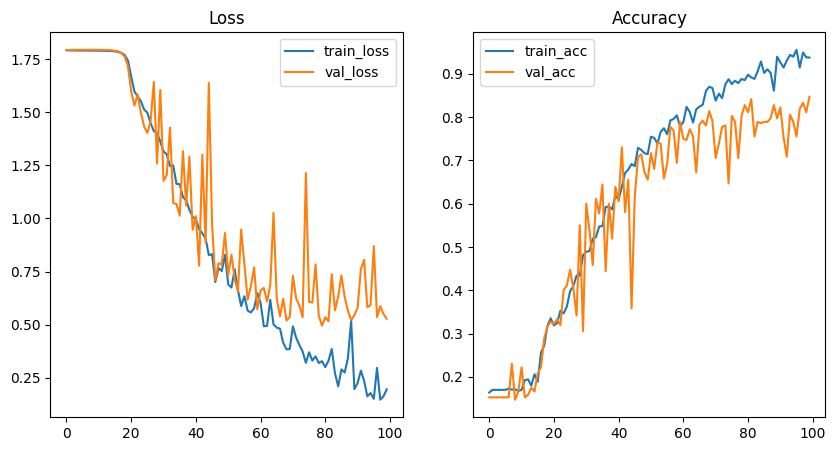

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save and load the model



1.   Save model weights only
2.   Save with model class architecture



1. Save model weights only

In [ ]:
# Save model weights
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# load model weights
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

2. Save with model class architecture

In [ ]:
torch.save(model, 'model.pth')

model = torch.load('model.pth')

#### Evaluation

In [ ]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [ ]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((360,), (360, 6), (360,))

In [ ]:
# calculate ACC
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

0.8472222222222222